# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the parameters, the model will still be limited by its vocabulary of only a few hundred words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

## Imports

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Some points to take so we get good results than previous is

### Key Considerations for Next-Word Prediction Using RNNs

1. **Large Corpus**:
   - **Diverse Data**: Utilize a large and diverse corpus to provide the model with a comprehensive understanding of language patterns, context, and vocabulary. This can significantly improve prediction accuracy and the quality of generated text.

2. **Preprocessing**:
   - **Data Cleaning**: Clean the text data by removing unwanted characters, punctuation, and converting everything to lower case.
   - **Tokenization**: Use text vectorization to convert words into numerical representations, allowing the model to process the text efficiently.
   - **Padding**: Ensure all sequences are padded to a consistent length, which is critical for batch processing in neural networks.

3. **Neural Network Design**:
   - **Higher Dimensional Embeddings**: Consider using higher-dimensional output for the embedding layer to capture more intricate relationships and meanings between words.
   - **Bidirectional LSTM**: Implement Bidirectional LSTM layers to allow the model to learn from context in both directions, enhancing its understanding of sequences.
   - **Increased LSTM Units**: Use a greater number of LSTM units to capture more complex patterns and relationships in the data.

4. **Learning Rate and Training Strategy**:
   - **Low Learning Rate**: Set a lower learning rate to allow for more gradual learning, which can lead to better convergence and potentially prevent overshooting optimal solutions.
   - **Epochs and Hyperparameter Tuning**: Experiment with a higher number of epochs and fine-tune hyperparameters (such as LSTM units, dropout rates, and batch size) to optimize performance further.

5. **Continuous Evaluation and Iteration**:
   - **Model Evaluation**: Regularly evaluate the model’s performance on validation data to ensure it generalizes well to unseen data.
   - **Adjustments**: Be prepared to make iterative adjustments to the model architecture and training process based on evaluation feedback.
6.  **Epochs**:
   - training for diff epochs also will help in getting good results
### Summary

Combining a large corpus with thoughtful preprocessing and a well-optimized neural network architecture—featuring higher-dimensional embeddings, Bidirectional LSTMs, and a carefully managed learning rate—will lead to a more effective next-word prediction model. Continuous hyperparameter tuning and evaluation will further refine the model, enabling it to generate more coherent and contextually relevant text. 

By focusing on these strategies, you can significantly enhance the performance and utility of your next-word prediction system.

## main problem
the main problem here is we are doing the ohe for the labels so large corpuses will have large ohe for each words and then we are predicting using that which will take large amount of data so for this we can go with the **`generating text using character based rnn`**

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt).

In [1]:
# The dataset has already beed downloaded for you, so no need to run the following line of code.
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

Next, you will lowercase and split the plain text into a list of sentences:

In [2]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

From here, you can initialize the `TextVectorization` class and generate the vocabulary:

In [5]:
# Initialize the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization()

# Build the vocabulary
vectorize_layer.adapt(corpus)

In [6]:
# Get the vocabulary and its size
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = len(vocabulary)

print(f'{vocabulary}')
print(f'{vocab_size}')

['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'of', 'my', 'in', 'me', 'for', 'you', 'all', 'was', 'she', 'that', 'on', 'with', 'her', 'but', 'as', 'when', 'love', 'is', 'your', 'it', 'will', 'from', 'by', 'they', 'be', 'are', 'so', 'old', 'he', 'oh', 'no', 'ill', 'at', 'one', 'his', 'were', 'there', 'heart', 'down', 'where', 'we', 'now', 'young', 'never', 'go', 'then', 'not', 'did', 'come', 'said', 'away', 'them', 'their', 'sweet', 'green', 'take', 'if', 'our', 'like', 'out', 'night', 'town', 'this', 'have', 'fair', 'day', 'can', 'true', 'thou', 'theres', 'see', 'or', 'more', 'its', 'had', 'dear', 'would', 'up', 'over', 'o', 'ive', 'hear', 'well', 'through', 'home', 'again', 'oer', 'land', 'im', 'ye', 'still', 'sea', 'long', 'left', 'good', 'father', 'wild', 'rose', 'morning', 'could', 'who', 'eyes', 'while', 'took', 'little', 'him', 'first', 'bow', 'back', 'an', 'some', 'shall', 'say', 'mary', 'man', 'let', 'know', 'high', 'gone', 'get', 'ever', 'came', 'till', 'rosin', 'put', 'own', 'm

## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [7]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(line).numpy()

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(sequence)):

		# Generate the subphrase
		n_gram_sequence = sequence[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

You can then print some of the examples as a sanity check.

In [8]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(vocabulary.index(word))

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[55, 13, 96, 1886, 49, 3, 71]


In [9]:
def sequence_to_text(sequence, vocabulary):
  '''utility to convert integer sequence back to text'''

  # Loop through the integer sequence and look up the word from the vocabulary
  words = [vocabulary[index] for index in sequence]

  # Combine the words into one sentence
  text = tf.strings.reduce_join(words, separator=' ').numpy().decode()

  return text

In [10]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   55   13   96 1886   49
    3]
decoded to text:          come all ye maidens young and
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 71


In [11]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   55   13   96 1886
   49]
decoded to text:           come all ye maidens young
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 3


Lastly, since this is a larger dataset, you can use the tf.data API to speed up the training.

In [12]:
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Put the inputs and labels to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((xs,ys))

# Optimize the dataset for training
dataset = dataset.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)

## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [13]:
# Parameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(max_sequence_len-1,)),
            tf.keras.layers.Embedding(vocab_size, embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
            tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 100)        │       270,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300)            │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2704)           │       813,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,504 (5.29 MB)

 Trainable params: 1,385,504 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [14]:
epochs = 100

# Train the model
history = model.fit(dataset, epochs=epochs)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0588 - loss: 6.8816
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0828 - loss: 5.9265
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1057 - loss: 5.8403
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1119 - loss: 6.2902
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1400 - loss: 5.4412
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1821 - loss: 4.6235
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2425 - loss: 3.8879
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2711 - loss: 3.7272
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3375 - loss: 3.1721
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3933 - loss: 2.7801
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4005 - loss: 2.8540
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━━

You can visualize the accuracy below to see how it fluctuates as the training progresses.

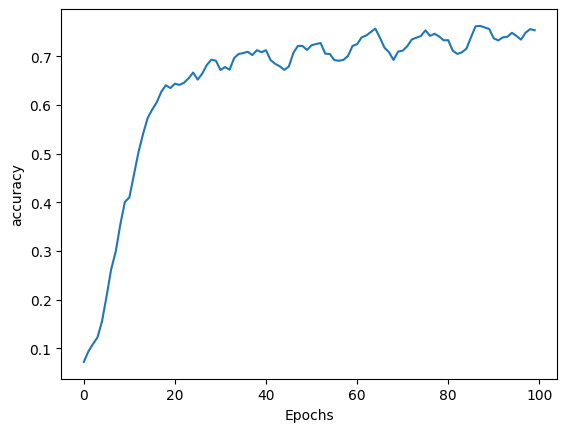

In [15]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [16]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(seed_text)

	# Pad the sequence
	sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(sequence, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = vocabulary[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope has been granted the color too i wear in gone gone away love gone and mine gone away wexford hill thee shaken friends for paddy rays there is setting there they may there right gone miss love be here and gone by gone and airy heavy odds he gone by love cornwall love gone by knitting now swings gone by and please ye hes toilworn and gone by gone and gone away gone as any lily and as ofttimes land easy unpaid easy as can take home away bells paddy but gone by and by daylight gone by gone and


Here again is the code that gets the top 3 predictions and picks one at random.

In [17]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
  sequence = vectorize_layer(seed_text)

	# Pad the sequence
  sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(sequence, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

    # Look up the word associated with the index.
    output_word = vocabulary[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope has been able away your hat in your eyes love so desolation id pipes gone gone when now since remarkable easy easy leg away winds made a tiny of blarney id gone thee bold her desolation as cry in me in days away me spirits rate law forbid across me brogue rigs gone ties gone ties gone down fulfill hiii erin lead here there agree out love love gone i love until native hat grave deprived gone away gone and call gone and gone and left my hat and throw for greet her find there quite useless ties gone far


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  

In [ ]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)